In [1]:
# ====== Core Libraries ======
import os
import random
import warnings
import numpy as np
import pandas as pd

# ====== Visualization ======
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid')

# ====== Image Processing ======
import cv2

# ====== Machine Learning Utilities ======
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# ====== TensorFlow / Keras ======
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation,
    BatchNormalization
)
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

# ====== Suppress Warnings ======
warnings.filterwarnings('ignore')

2025-07-06 16:13:33.569411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751818413.763713      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751818413.816665      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define the path to the dataset
dataset_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

def build_dataframe(root_dir):
    image_paths = []
    image_labels = []

    # Traverse each class directory
    for label_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, label_name)

        # Ensure it's a directory
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                image_paths.append(file_path)
                image_labels.append(label_name)

    # Create and return the DataFrame
    return pd.DataFrame({
        'Filepaths': image_paths,
        'Labels': image_labels
    })

# Create the DataFrame
df = build_dataframe(dataset_path)

In [3]:
# Split into training (80%) and remaining (20%)
train_df, remaining_df = train_test_split(
    df, 
    train_size=0.8, 
    shuffle=True, 
    random_state=42
)

# Split the remaining 20% into validation (10%) and test (10%)
valid_df, test_df = train_test_split(
    remaining_df, 
    test_size=0.5,
    shuffle=True, 
    random_state=42
)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size as constants
IMG_SIZE = (150, 150)
BATCH_SIZE = 64
SEED = 42

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation and test: only rescaling
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Helper function to create generators
def create_generator(datagen, dataframe, shuffle, name):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='Filepaths',
        y_col='Labels',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle,
        seed=SEED
    )

# Create generators
train_generator = create_generator(train_datagen, train_df, shuffle=True, name="Train")
valid_generator = create_generator(val_test_datagen, valid_df, shuffle=False, name="Validation")
test_generator  = create_generator(val_test_datagen, test_df,  shuffle=False, name="Test")

Found 69600 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [5]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3),
    pooling='max'
)




model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')  
])


model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

I0000 00:00:1751818624.271922      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,135,685 (80.63 MB)

 Trainable params: 21,077,061 (80.40 MB)

 Non-trainable params: 58,624 (229.00 KB)

In [6]:
# Train the model and save training history
history = model.fit(
    x=train_generator,
    validation_data=valid_generator,
    epochs=5,
    verbose=1,
    shuffle=False
)

Epoch 1/5


I0000 00:00:1751818660.263775      95 service.cc:148] XLA service 0x7a1108002990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751818660.264798      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751818662.925724      95 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751818672.624206      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751818672.825807      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751818673.868821      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751818674.0596

1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.8077 - loss: 0.7488

E0000 00:00:1751819374.262170      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751819374.457729      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751819375.117647      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751819375.303489      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751819375.888497      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 814s 697ms/step - accuracy: 0.8079 - loss: 0.7479 - val_accuracy: 0.9980 - val_loss: 0.0070
Epoch 2/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 502s 461ms/step - accuracy: 0.9805 - loss: 0.0764 - val_accuracy: 0.9992 - val_loss: 0.0013
Epoch 3/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 440s 404ms/step - accuracy: 0.9858 - loss: 0.0591 - val_accuracy: 0.9984 - val_loss: 0.0072
Epoch 4/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 439s 403ms/step - accuracy: 0.9891 - loss: 0.0440 - val_accuracy: 0.9998 - val_loss: 9.3388e-04
Epoch 5/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 445s 409ms/step - accuracy: 0.9914 - loss: 0.0346 - val_accuracy: 0.9992 - val_loss: 0.0015


In [7]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

136/136 ━━━━━━━━━━━━━━━━━━━━ 51s 377ms/step - accuracy: 0.9995 - loss: 0.0013
Test Accuracy: 0.9996551871299744


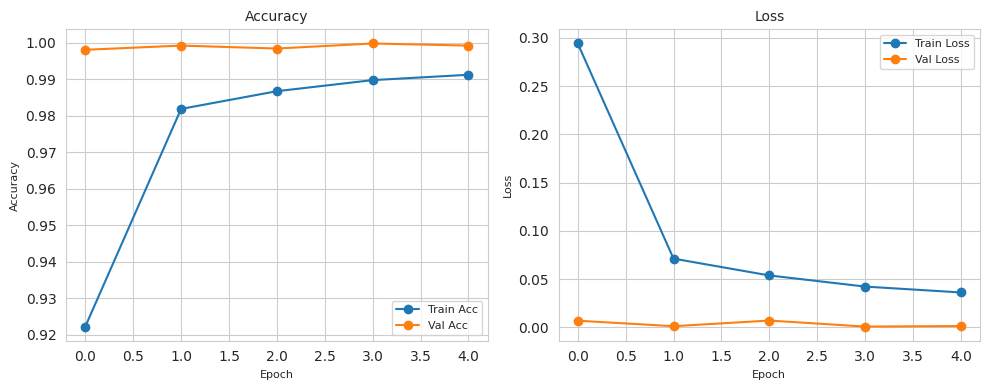

In [8]:
plt.figure(figsize=(10, 4)) 

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy', fontsize=10)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Accuracy', fontsize=8)
plt.legend(fontsize=8)
plt.grid(True)

# Subplot 2: Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss', fontsize=10)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Loss', fontsize=8)
plt.legend(fontsize=8)
plt.grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/accuracy_loss_plot.png')
plt.show()

136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step


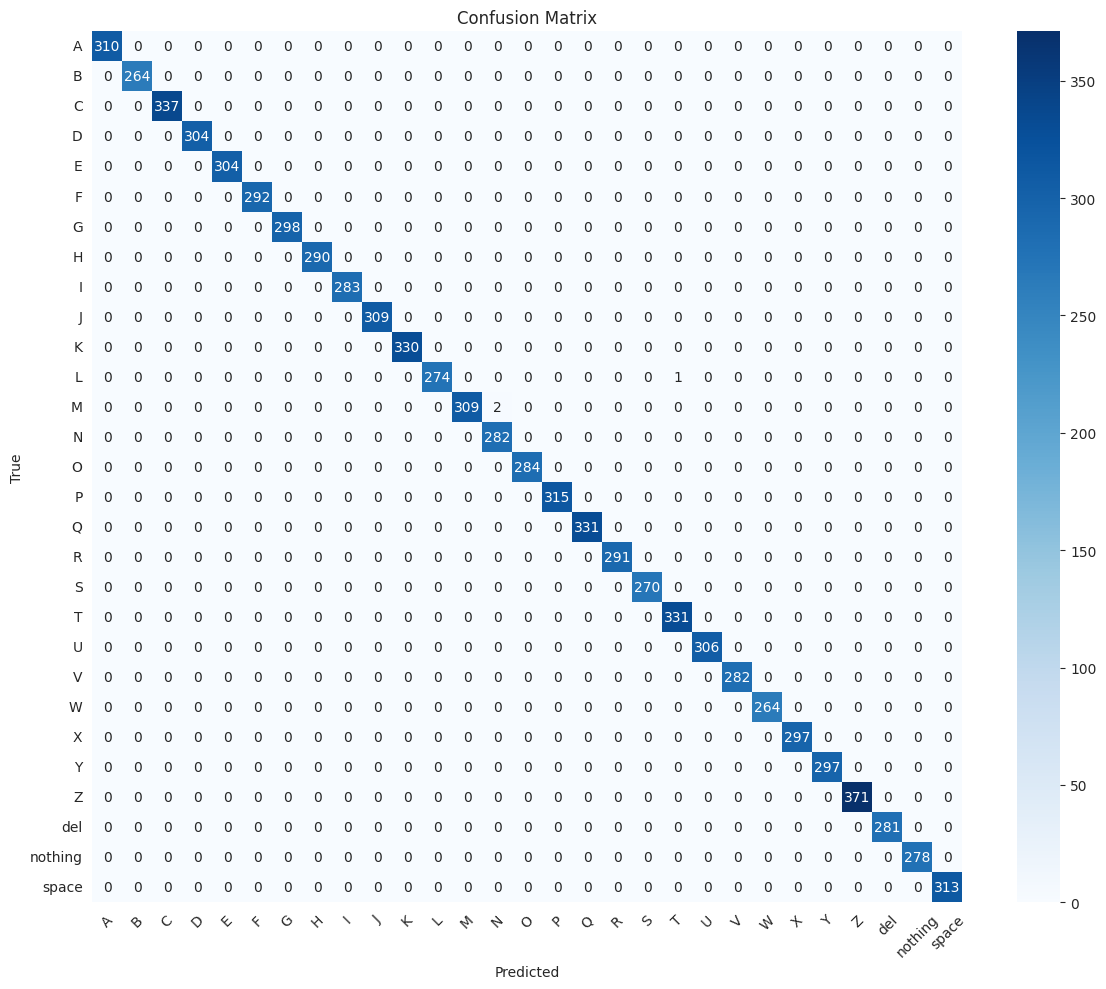

In [9]:
# Confusion Matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


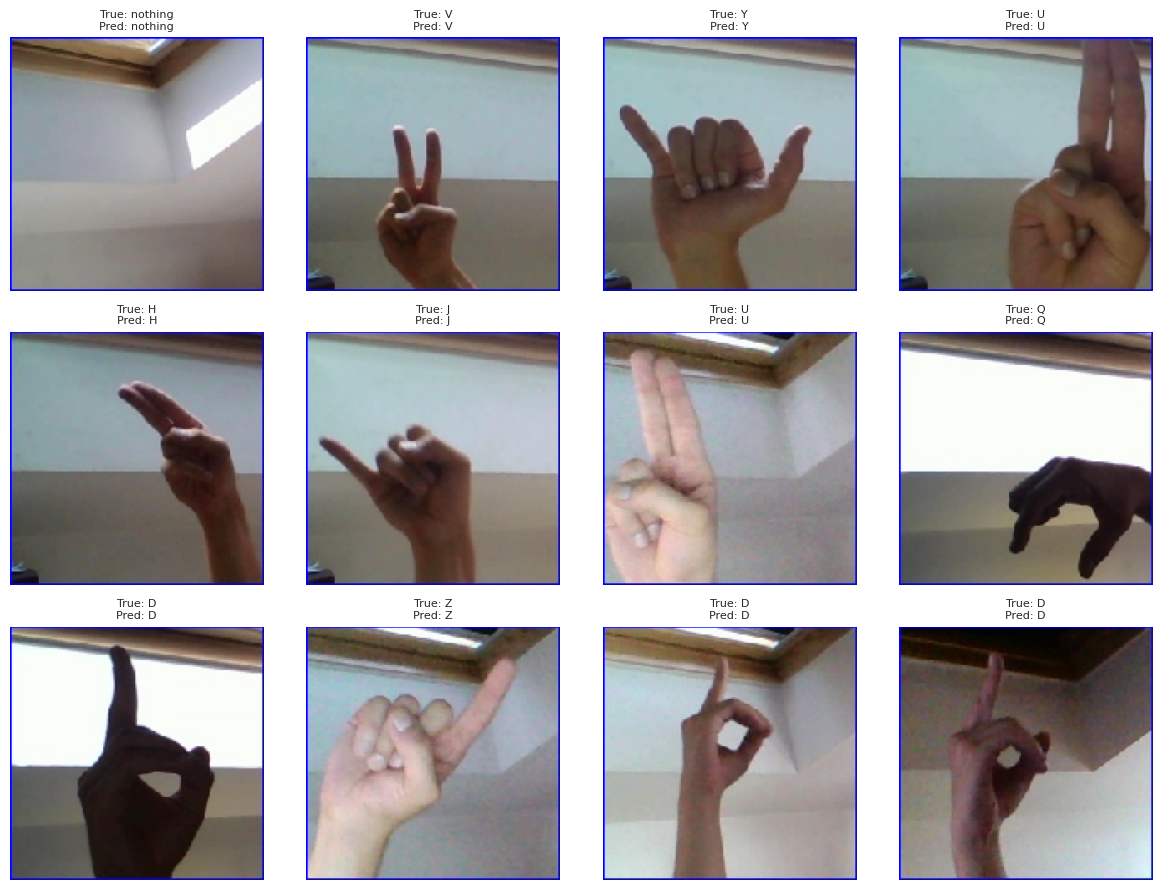

In [10]:

# Sample Predictions with 12 images
def plot_sample_predictions(generator, model, num_samples=12):
    generator.reset()
    images, labels = next(generator) 
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(labels, axis=1)
    class_labels = list(generator.class_indices.keys())
    
    plt.figure(figsize=(12, 9))
    for i in range(num_samples):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i])
        plt.title(f"True: {class_labels[true_labels[i]]}\nPred: {class_labels[pred_labels[i]]}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/kaggle/working/sample_predictions_12.png')
    plt.show()

plot_sample_predictions(test_generator, model, num_samples=12)

In [12]:
model.save("model_gusture.keras")